In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import ndimage
import trilinear
from glob import glob
import codecs
import tempfile
from TX import cmb, upf
from scipy.interpolate import griddata

** joblib was not found - will not be used in TX.upf


In [3]:
cnt="""C+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
      subroutine trilinear(cijk,xyz,x0,x1,y0,y1,z0,z1,c)
      implicit none
      real*8,intent(in)::cijk(0:1,0:1,0:1),x0,x1,y0,y1,z0,z1,
     $     xyz(3)
      real*8,intent(out)::c
c     locals
      real*8 x,y,z,xd,yd,zd,c00,c01,c10,c11,c0,c1
      x=xyz(1)
      y=xyz(2)
      z=xyz(3)

c     distance
      xd=(x-x0)/(x1-x0)
      yd=(y-y0)/(y1-y0)
      zd=(z-z0)/(z1-z0)

c     Apply linear interpolation on the top and bottom faces
c     to obtain two separate interpolants on the respective faces.
      c00=cijk(0,0,0)*(1-xd)+cijk(1,0,0)*xd
      c01=cijk(0,0,1)*(1-xd)+cijk(1,0,1)*xd
      c10=cijk(0,1,0)*(1-xd)+cijk(1,1,0)*xd
      c11=cijk(0,1,1)*(1-xd)+cijk(1,1,1)*xd

c     linear interpolation using the two interpolants
c     on the top and bottom faces
      c0=c00*(1-yd)+c10*yd
      c1=c01*(1-yd)+c11*yd

      c=c0*(1-zd)+c1*zd
      return
      end subroutine trilinear
"""
with open('trilinear.f','w') as fo:
    fo.write(cnt)

In [4]:
!cat trilinear.f

C+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
      subroutine trilinear(cijk,xyz,x0,x1,y0,y1,z0,z1,c)
      implicit none
      real*8,intent(in)::cijk(0:1,0:1,0:1),x0,x1,y0,y1,z0,z1,
     $     xyz(3)
      real*8,intent(out)::c
c     locals
      real*8 x,y,z,xd,yd,zd,c00,c01,c10,c11,c0,c1
      x=xyz(1)
      y=xyz(2)
      z=xyz(3)

c     distance
      xd=(x-x0)/(x1-x0)
      yd=(y-y0)/(y1-y0)
      zd=(z-z0)/(z1-z0)

c     Apply linear interpolation on the top and bottom faces
c     to obtain two separate interpolants on the respective faces.
      c00=cijk(0,0,0)*(1-xd)+cijk(1,0,0)*xd
      c01=cijk(0,0,1)*(1-xd)+cijk(1,0,1)*xd
      c10=cijk(0,1,0)*(1-xd)+cijk(1,1,0)*xd
      c11=cijk(0,1,1)*(1-xd)+cijk(1,1,1)*xd

c     linear interpolation using the two interpolants
c     on the top and bottom faces
      c0=c00*(1-yd)+c10*yd
      c1=c01*(1-yd)+c11*yd

      c=c0*(1-zd)+c1*zd
      return
      end subroutine trilinear


In [5]:
!f2py -c trilinear.f  -m trilinear > /dev/null

In file included from /var/folders/q5/3zv1p7vn5tgd8vnh27x5w7vr0000gn/T/tmp8hw9lwbd/src.macosx-11.0-x86_64-3.8/trilinearmodule.c:18:
In file included from /Users/youngung/.pyenv/versions/3.8.6/include/python3.8/Python.h:25:
In file included from /Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/stdio.h:64:
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:93:16: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]
        unsigned char   *_base;
In file included from                         ^/var/folders/q5/3zv1p7vn5tgd8vnh27x5w7vr0000gn/T/tmp8hw9lwbd/src.macosx-11.0-x86_64-3.8/fortranobject.c
:2:
In file included from /var/folders/q5/3zv1p7vn5tgd8vnh27x5w7vr0000gn/T/tmp8hw9lwbd/src.macosx-11.0-x86_64-3.8/fortranobject.h:7:
In file included from /Users/youngung/.pyenv/versions/3.8.6/include/python3.8/Python.h:25:
In file included from /Library/Developer/CommandLineTools/SDKs

In [6]:
!head ~/repo/evpsc/matData/vpscData/DP_RGVB/KIMS_F.odf

% MTEX ODF
% crystal symmetry: "m-3m"
% specimen symmetry: "1"
% phi1    Phi     phi2    value
0.00000 0.00000 0.00000 0.36418
5.00000 0.00000 0.00000 0.51916
10.00000 0.00000 0.00000 0.70934
15.00000 0.00000 0.00000 0.84879
20.00000 0.00000 0.00000 0.87935
25.00000 0.00000 0.00000 0.84331


In [7]:
fns=glob('../Steglich_230803/ODF_MgGd10_*.txt')

fns_odf=[]
for i, fn in enumerate(fns):
    with open(fn, 'r',errors='replace') as fo: 
        cnt=fo.read()#Kerrors='ignore')
        cnt=cnt.split('ODF')[1]
        cnt=cnt.split('\n')
        print(cnt[:3])
        cnt=cnt[3:]
    cnt=cnt[:-1]
    fn_odf_mtex=tempfile.mktemp()
    fns_odf.append(fn_odf_mtex)
    with open(fn_odf_mtex,'w') as fo:
        for i, line in enumerate(cnt):
            fo.write(f'{line}\n')
        
    print(fn_odf_mtex)
    #myrve=cmb.RVE()

['', '# Resolution [degrees]: 5.00000 5.00000 5.00000', '# Bunge Euler Angles: phi1, PHI, phi2']
/var/folders/q5/3zv1p7vn5tgd8vnh27x5w7vr0000gn/T/tmpvkysfnsx
['', '# Resolution [degrees]: 5.00000 5.00000 5.00000', '# Bunge Euler Angles: phi1, PHI, phi2']
/var/folders/q5/3zv1p7vn5tgd8vnh27x5w7vr0000gn/T/tmp7e_nf6cb


In [8]:
for i in range(2):
    !head -n 2 {fns_odf[i]}
    print('--')
    !tail -n 3 {fns_odf[i]}
    print('==\n')

   0.00000    0.00000    0.00000 1.50901
   0.00000    0.00000    5.00000 0.478483
--
 180.00000  180.00000  170.00000 0.20666
 180.00000  180.00000  175.00000 0.454255
 180.00000  180.00000  180.00000 1.50901
==

   0.00000    0.00000    0.00000 0.0825355
   0.00000    0.00000    5.00000 0.709639
--
 180.00000  180.00000  170.00000 1.35901
 180.00000  180.00000  175.00000 0.739112
 180.00000  180.00000  180.00000 0.082536
==



180.0 180.0 180.0
phi1, phi, phi2 180.0 180.0 180.0
Elapsed time for calling cells_pf:          17 [ ms]180.0 180.0 180.0
phi1, phi, phi2 180.0 180.0 180.0
Elapsed time for calling cells_pf:          17 [ ms]

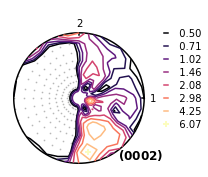

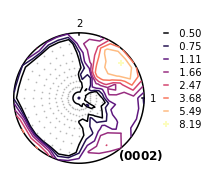

In [25]:
res=5.
ngrain=1000

fn_texs=[]
for ifile, fn in enumerate(fns_odf):
    fn_tex=tempfile.mktemp()
    fn_texs.append(fn_tex)
    dat_flat=np.loadtxt(fn).T
    phi1,phi,phi2,weights=dat_flat[0],dat_flat[1],dat_flat[2],dat_flat[3]
    
    print(max(phi1),max(phi2),max(phi))
    nx=int((max(phi1)-min(phi1))/res + 1)
    ny=int((max(phi) -min(phi)) /res + 1)
    nz=int((max(phi2)-min(phi2))/res + 1)
    odf=np.zeros((nx,ny,nz),dtype='float')

    for k, wgt in enumerate(weights):
        p1,p,p2=phi1[k],phi[k],phi2[k]
        ix=int(p1/res)-1
        iy=int(p /res)-1
        iz=int(p2/res)-1
        odf[ix,iy,iz]=wgt

    rand_pop=cmb.random(max(phi1),max(phi2),max(phi),ngrain=ngrain,iplot=False)    

    for igr, gr in enumerate(rand_pop):
        p1,p,p2,w=gr

        #print('chosen angles %5.1f %5.1f %5.1f'%(p1,p,p2))
        r =np.zeros((3,2))
        ir=np.zeros((3,2),dtype='int')

        r[0,0]=p1-mod(p1,res)
        r[0,1]=p1-mod(p1,res)+res
        r[1,0]=p -mod(p ,res)
        r[1,1]=p -mod(p ,res)+res
        r[2,0]=p2-mod(p2,res)
        r[2,1]=p2-mod(p2,res)+res

        for i in range(3):
            for j in range(2):
                ir[i,j]=int((r[i,j]+res)/res)-1

        cijk=np.zeros((2,2,2))                
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    ix=ir[0,i]
                    iy=ir[1,j]
                    iz=ir[2,k]
                    
                    phi1=(ix-1)*res
                    phi =(iy-1)*res
                    phi2=(iz-1)*res

                    #print('ix,iy,iz:',ix,iy,iz)
                    
                    cijk[i,j,k]=odf[ix,iy,iz]
                    
        xyz=[p1,p,p2]
        val=trilinear.trilinear(cijk,xyz,
                            r[0,0],r[0,1],r[1,0],r[1,1],r[2,0],r[2,1])
        
        rand_pop[igr,:]=p1,p,p2,val
        
    with open(fn_tex,'w') as fo:
        fo.write(f'\n\n\n B {ngrain}\n')
        for igr in range(ngrain):
            fo.write('%f %f %f %f \n'%(rand_pop[igr,0],rand_pop[igr,1],rand_pop[igr,2],rand_pop[igr,3]))

    mypf=upf.polefigure(grains=rand_pop,csym='hexag',cdim=[1,1,1.624],cang=[90,90,120])
    mypf.pf_new(poles=[[0,0,0,2]])

In [26]:
def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

180.0 180.0 180.0


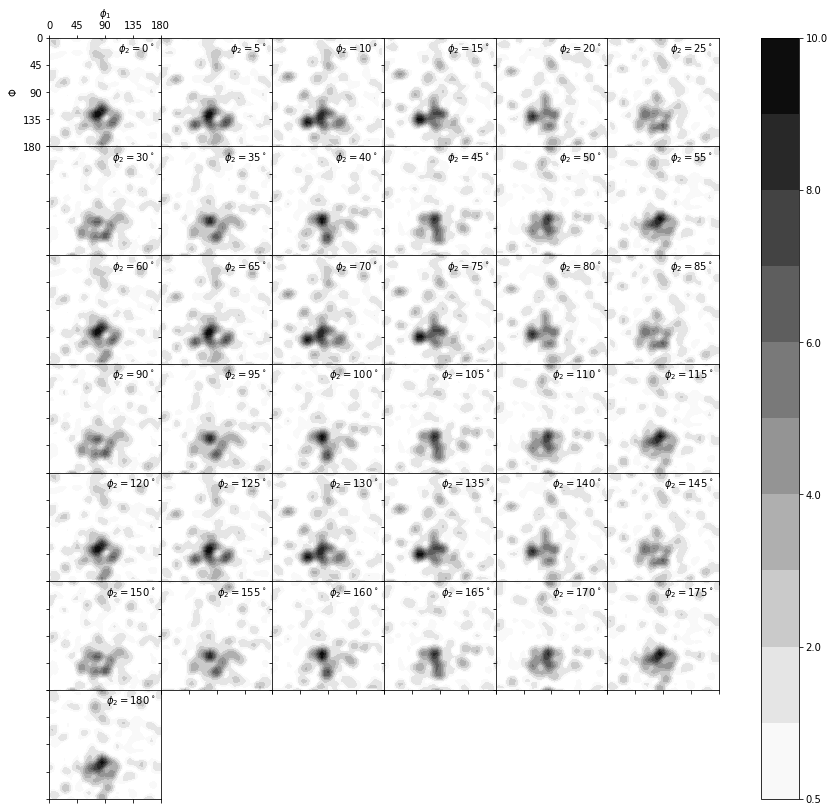

In [27]:
dat_flat=np.loadtxt(fn).T
incr=5.
phi1,phi,phi2,weights=dat_flat[0],dat_flat[1],dat_flat[2],dat_flat[3]

print(max(phi1),max(phi2),max(phi))
nx=int((max(phi1)-min(phi1))/res + 1)
ny=int((max(phi) -min(phi)) /res + 1)
nz=int((max(phi2)-min(phi2))/res + 1)
odf=np.zeros((nx,ny,nz),dtype='float')

for k, wgt in enumerate(weights):
    p1,p,p2=phi1[k],phi[k],phi2[k]
    ix=int(p1/res)-1
    iy=int(p /res)-1
    iz=int(p2/res)-1
    odf[ix,iy,iz]=wgt
    
phi1s=np.arange(min(phi1),max(phi1)+incr,incr)
phis =np.arange(min(phi), max(phi) +incr,incr)

phi2_disc=np.linspace(0.,max(phi2),int(max(phi2)/incr)+1)



ncols=int(sqrt(ny))
nrows=int(ny/ncols)+1

fig,axes=gen_fig(nrows=nrows,ncols=ncols,wspace=0,hspace=0)

phi2_sections=np.linspace(0,max(phi2),int(max(phi2)/incr+1))
for i, phi2_section in enumerate(phi2_sections):
    iphi2=int(phi2_section/incr)
    section=odf[:,:,iphi2]
    P1,P3=np.meshgrid(phi1s,phis)
    ax=fig.axes[i]
    cnt=ax.contourf(P1,P3,section,cmap='gray_r',levels=[0.5,1,2,3,4,5,6,7,8,9,10])
    ax.set_ylim(max(phi),min(phi))
    ax.set_xlim(min(phi1),max(phi1))
    ax.set_xticks(np.linspace(min(phi1),max(phi1),5))#[0,90,180])
    ax.set_yticks(np.linspace(min(phi) ,max(phi), 5))    
    #ax.set_yticks()#[0,90,180])
    ax.text(0.95,0.9,ha='right',va='center',
            s=r'$\phi_2=%i^\circ{}$'%(i*incr),
            transform=ax.transAxes)

for k in range(nz,ncols*nrows):
    fig.axes[k].set_axis_off()    
    
fig.axes[0].xaxis.set_label_position('top') 
fig.axes[0].xaxis.set_ticks_position('top') 
fig.axes[0].set_xlabel(r'$\phi_1$')
fig.axes[0].set_ylabel(r'$\Phi$')

for i, ax in enumerate(fig.axes[1:]):
    ax.set_xticklabels([], minor=False)
    ax.set_yticklabels([], minor=False)    
    
#axes[0].colorbar()
plt.colorbar(mappable=cnt,ax=axes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


***  number of grain: 3087  ***
Total volume: 1101.3
max:  90.0 90.0 90.0
min:  0.0 0.0 0.0
FULL INTEGRATION VALUE: 0.2 * pi * pi
section at phi2 = 45.0
rdi: 0.137078
x: 0.0 ~ 90.0
y: 0.0 ~ 90.0
z: 0.0 ~ 90.0
nnx, nny, and f.shape 18 18 (18, 18)
levels:  [ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]


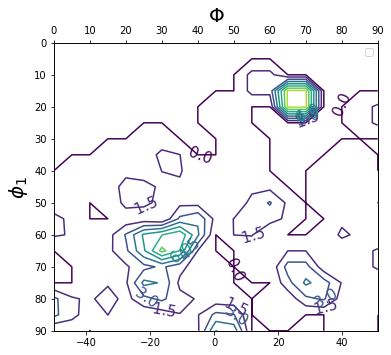

In [37]:
from MP import read_blocks
from TX import cod_section
read_blocks.read_tx
#fn='/Users/youngung/repo/evpsc/TEX_PH1.OUT'
fn=fn_texs[0]
pxs,ngrs=read_blocks.read_tx(fn)
dum=cod_section.main(resolution=5.,gr=pxs[-1,:,:].T,phi2=45.)

<function MP.read_blocks.read_tx(fn='TEX_PH1.OUT')>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


***  number of grain: 3087  ***
Total volume: 1101.3
max:  90.0 90.0 90.0
min:  0.0 0.0 0.0
FULL INTEGRATION VALUE: 0.2 * pi * pi
section at phi2 = 45.0
rdi: 0.137078
x: 0.0 ~ 90.0
y: 0.0 ~ 90.0
z: 0.0 ~ 90.0
nnx, nny, and f.shape 18 18 (18, 18)
levels:  [ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]


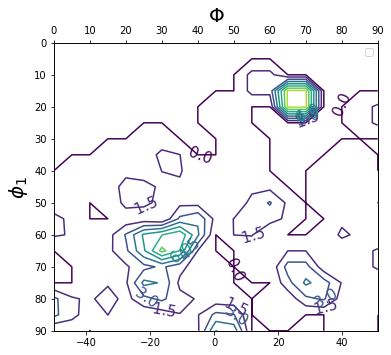

In [284]:
px=pxs[-1,:,:]
incr=np.deg2rad(5.)
xi=np.arange(-pi,pi+0.01,incr)*180./np.pi
yi =np.arange(0,pi/4+0.01,incr)*180./np.pi
zi=np.arange(-pi,pi+0.01,incr)*180./np.pi

xi,yi,zi=np.meshgrid(xi,yi,zi)


In [325]:
px.shape

(4, 1000)

In [327]:
px.shape

(4, 1000)

In [313]:

zi=griddata(px[:3].T,px[3],(xi,yi,zi),method='linear')

In [314]:
from scipy.interpolate import LinearNDInterpolator

In [318]:
linInter=LinearNDInterpolator(px[:3].T,px[3])

In [323]:
linInter([10,50,0.1])

array([0.001])